### Testing SHAP and PCA approach
SHapley Additive exPlanations


**Objective**: Identify the most important features using SHAP values, then train a parsimonious model for energy usage prediction.

**Approach**:
1. Preprocess data using custom scalers
2. Train initial Gradient Boosting model
3. Compute SHAP values for feature importance
4. Select top features based on SHAP importance
5. Retrain model with selected features
6. Evaluate performance

In [67]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from custom_scaler import column_transformer, tree_column_transformer
from utils import ModelComparator

warnings.filterwarnings('ignore')

In [40]:
X_train = np.loadtxt('x_train.txt')
y_train = np.loadtxt('y_train.txt').astype(int)

In [43]:
RANDOM_STATE = 42
TOP_K_FEATURES = 5
TOP_PERCENTILE = 20

In [44]:
# initializing scaler
scaler = tree_column_transformer
X_scaled = scaler.fit_transform(X_train)

In [ ]:
# initializing base model
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=4,
    random_state=RANDOM_STATE,
    subsample=0.8
)

In [ ]:
def compute_shap_importance(model, X, n_samples=1000):
    """Compute SHAP values and return feature importance"""
    if len(X) > n_samples:
        sample_idx = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[sample_idx]
    else:
        X_sample = X

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # take mean absolute of SHAP values
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])  # Class 1 
    else:
        shap_values = np.abs(shap_values)

    feature_importance = np.mean(shap_values, axis=0)

    return feature_importance

In [50]:
gb_model.fit(X_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=150,
                           random_state=42, subsample=0.8)

In [51]:
# Get SHAP importance
shap_importance = compute_shap_importance(gb_model, X_scaled)

# Select top features
top_feature_indices = np.argsort(shap_importance)[-TOP_K_FEATURES:]
top_feature_scores = shap_importance[top_feature_indices]

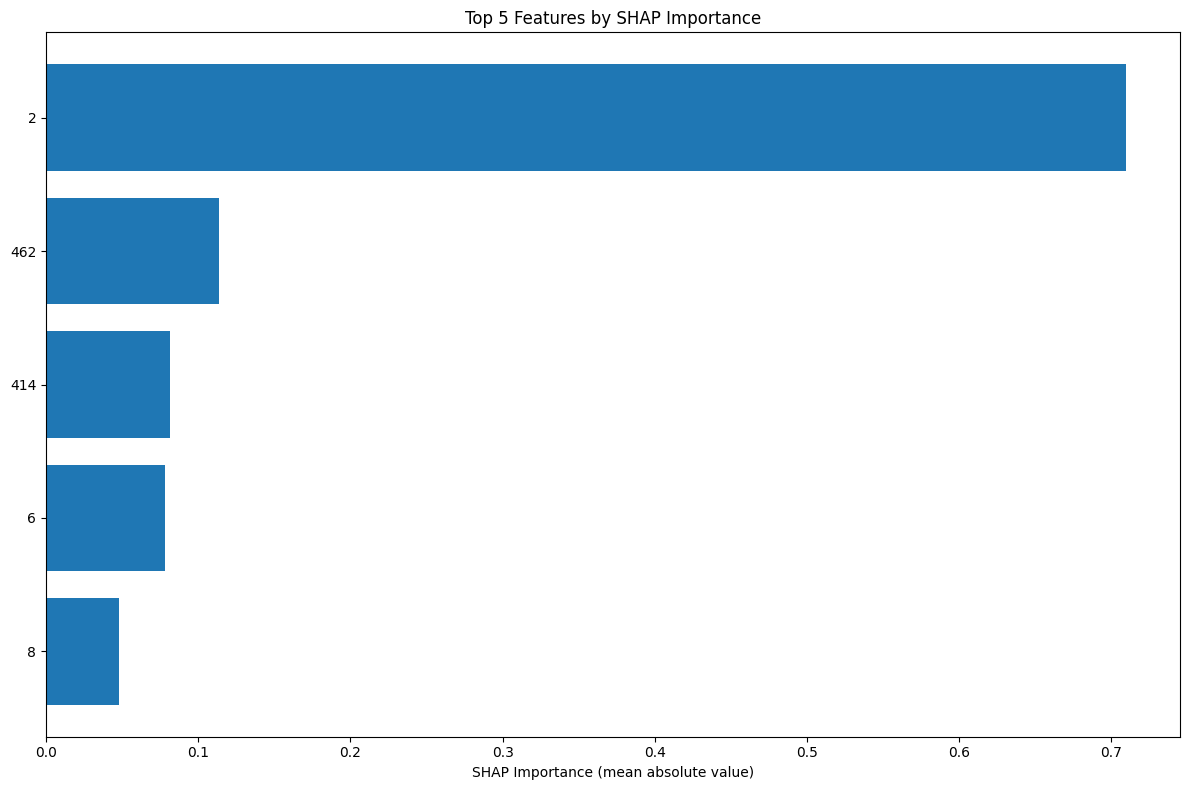

In [52]:
plt.figure(figsize=(12, 8))
plt.barh(range(TOP_K_FEATURES), top_feature_scores, align='center')
plt.yticks(range(TOP_K_FEATURES), top_feature_indices)
plt.xlabel("SHAP Importance (mean absolute value)")
plt.title(f"Top {TOP_K_FEATURES} Features by SHAP Importance")
plt.tight_layout()
plt.show()

In [60]:
display(top_feature_scores)
display(top_feature_indices)

array([0.04815461, 0.0780573 , 0.08113382, 0.11334832, 0.70960221])

array([  8,   6, 414, 462,   2], dtype=int64)

In [53]:
X_reduced = X_scaled[:, top_feature_indices]

# Retrain model on selected features
final_model = clone(gb_model)
final_model.fit(X_reduced, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=150,
                           random_state=42, subsample=0.8)

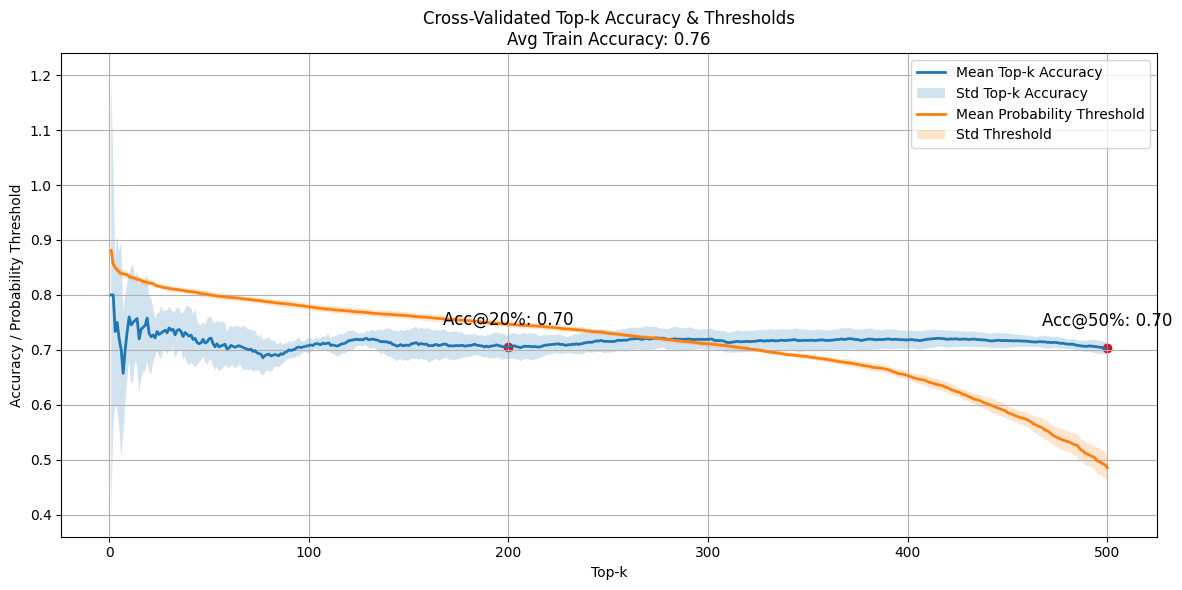

Test Accuracies (Overall): 0.71 ± 0.01
Final model accuracy (top 20%): 0.7065
Selected features: [  8   6 414 462   2]


In [54]:
# Evaluate performance
model_comp_reduced = ModelComparator(X_reduced, y_train, scaling=None, random_state=RANDOM_STATE)
final_acc = model_comp_reduced.evaluate_model(final_model)
print(f"Final model accuracy (top 20%): {final_acc:.4f}")
print(f"Selected features: {top_feature_indices}")

Checking performance for the 2 most important features - 2, 462

In [55]:
X_reduced = X_scaled[:, [2, 462]]

final_model = clone(gb_model)
final_model.fit(X_reduced, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=150,
                           random_state=42, subsample=0.8)

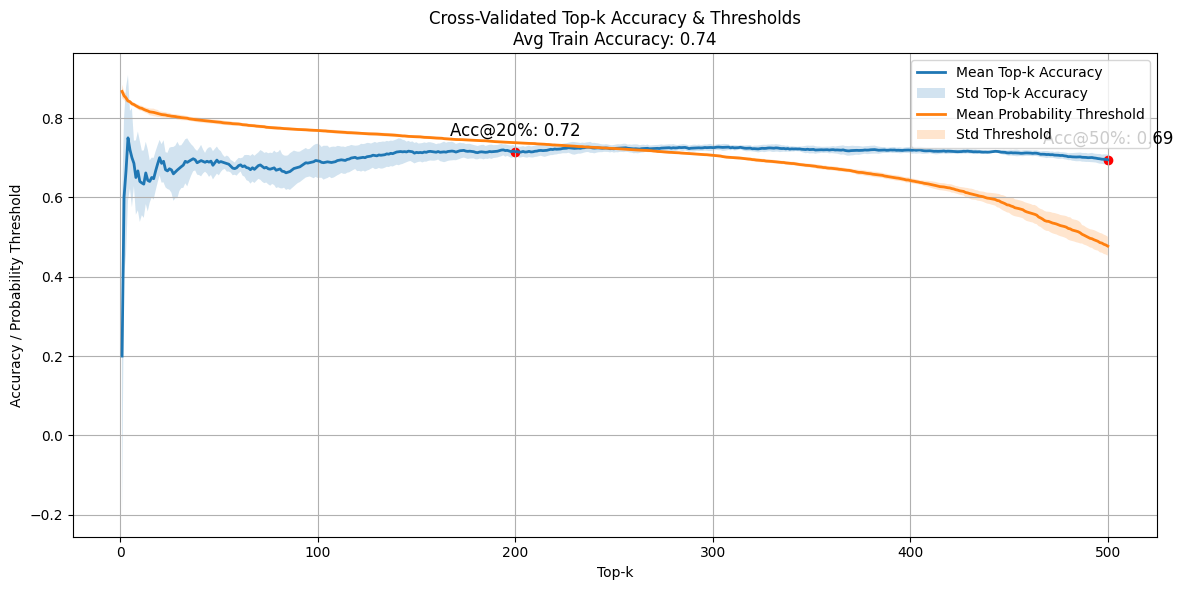

Test Accuracies (Overall): 0.71 ± 0.01
Final model accuracy (top 20%): 0.7154
Selected features: 2, 462


In [57]:
model_comp_reduced = ModelComparator(X_reduced, y_train, scaling=None, random_state=RANDOM_STATE)
final_acc = model_comp_reduced.evaluate_model(final_model)
print(f"Final model accuracy (top 20%): {final_acc:.4f}")
print(f"Selected features: 2, 462")

#### PCA + Logistic Regression
Principal component analysis

**Objective**: Handle high correlation in first 10 variables while incorporating SHAP-selected features.

**Key Insights**:
- First 10 variables are highly correlated (from problem statement)
- SHAP analysis showed important features: [2, 462, 414]
- PCA will reduce dimensionality of correlated features
- Logistic regression provides interpretable probabilities

In [62]:
shap_features = [462, 2]  # From SHAP analysis
first_10_correlated = list(range(10))  # First 10 correlated features

We'll create three feature groups:
1. PCA components from first 10 correlated variables
2. SHAP-selected features (excluding those in first 10)

In [72]:
class PCAShapFeatureEngineer:
    def __init__(self, n_pca_components=3, shap_features=None):
        self.n_pca_components = n_pca_components
        self.shap_features = shap_features if shap_features else []
        self.pca = PCA(n_components=n_pca_components)

    def fit(self, X, y=None):
        # Fit PCA on first 10 features
        self.pca.fit(X[:, :10])
        return self

    def transform(self, X):
        # PCA transform first 10 features
        pca_features = self.pca.transform(X[:, :10])

        # Get SHAP features not in first 10
        shap_to_keep = [f for f in self.shap_features if f >= 10]
        shap_values = X[:, shap_to_keep] if shap_to_keep else np.zeros((X.shape[0], 0))

        return np.hstack([pca_features, shap_values])

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [73]:
pipeline = Pipeline([
    ('scaler', column_transformer),  # From custom_scaler.py
    ('feature_engineer', PCAShapFeatureEngineer(n_pca_components=3, shap_features=shap_features)),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42))
])

In [74]:
fe = PCAShapFeatureEngineer(n_pca_components=3, shap_features=shap_features)
X_transformed = fe.fit_transform(column_transformer.fit_transform(X_train))


In [75]:
pca_feats = [f"PCA_{i}" for i in range(fe.n_pca_components)]
shap_feats = [f"SHAP_{f}" for f in shap_features if f >= 10]
all_feature_names = pca_feats + shap_feats

print(f"Final feature set ({len(all_feature_names)} features):")
print(all_feature_names)

Final feature set (4 features):
['PCA_0', 'PCA_1', 'PCA_2', 'SHAP_462']



Full Model Evaluation:


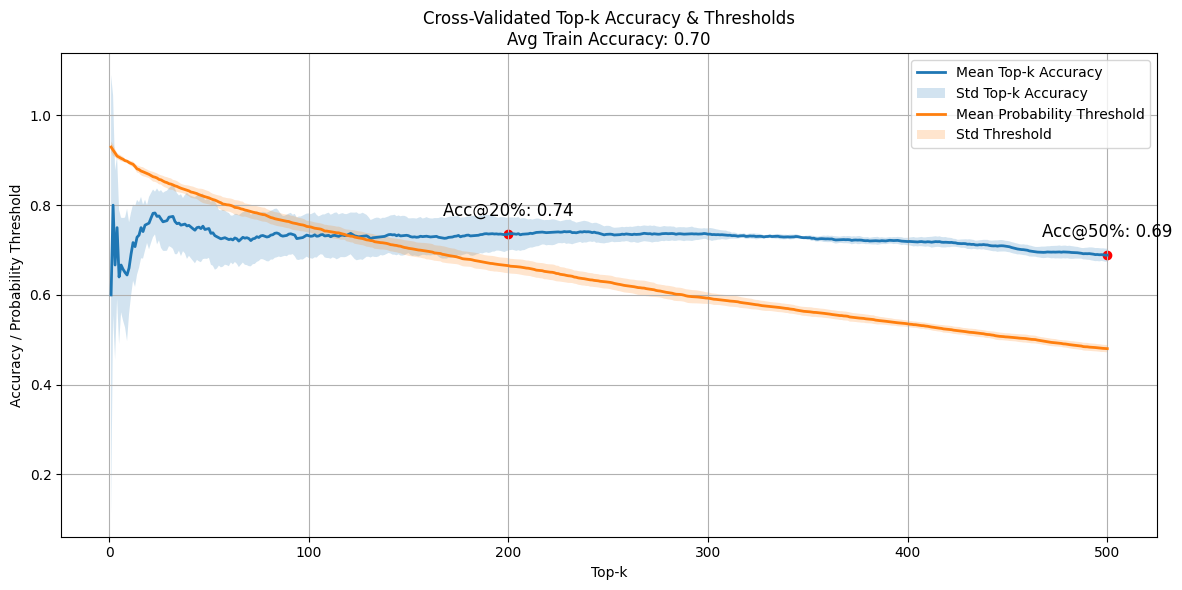

Test Accuracies (Overall): 0.70 ± 0.01


In [76]:
model_comp = ModelComparator(
    X_transformed,
    y_train,
    scaling=None,  #already scaled in pipeline
    random_state=42
)

# Comprehensive evaluation
print("\nFull Model Evaluation:")
top_k_acc = model_comp.evaluate_model(pipeline.named_steps['classifier'])